In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

filename = "AMAZON_FASHION_5.json"

df = pd.read_json(path_or_buf=filename, lines=True)




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/shy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [67]:
df['asin'].value_counts()

B009MA34NY    377
B0092UF54A    376
B010RRWKT4    376
B005AGO4LU    376
B014IBJKNO    375
B0014F7B98    374
B0058YEJ5K    367
B001IKJOLW    365
B000YFSR5G     56
B000YFSR4W     36
B000K2PJ4K     10
B0017LD0BM     10
B0017LGD34     10
B00RLSCLJM      9
B0014F8TIU      8
B00G8Q7JZ4      8
B001LNSY2Q      7
B000V0IBDM      7
B000KPIHQ4      7
B0014HA6VG      4
B00I0VHS10      4
B0012DR1LU      4
B00ND9047Y      2
B01H7KY678      1
B016XAJLVO      1
B01595OS62      1
B00MLYE8PQ      1
B00ZUA6AJK      1
B00LKWYX2I      1
B00GKF5BAS      1
B003M6060S      1
Name: asin, dtype: int64

In [85]:
list(df[df['asin'] == 'B009MA34NY']['reviewText'])

['I always get a half size up in my tennis shoes. For some reason these feel to big in the heel area and wide.',
 'Put them on and walked 3 hours with no problem! Love them! So light feeling',
 'excelente',
 'The shoes fit well in the arch area. They are a little wider in the toe area of the shoe, you feel like you have a lot of room. This does not make the shoe uncomfortable, just had to get used to it. Love the shoe.',
 "Tried them on in a store before buying online so I knew they'd fit good. Overall I was looking for a durable cross training shoe that would hold up to my rigorous training and these have been great so far. They are really light and comfortable. Most importantly for me they have grips on the bottoms so my feet don't slide out from under me while doing planks, push-ups, etc. Highly satisfied with this purchase.",
 'I recommend that!',
 "My son likes these, and this is the 2nd pair he's worn.",
 'Comfortable',
 'Fit fine...did not like color in person',
 'The shoe is to

In [69]:
import json

#filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"
with open(filename) as f:
    reviews_json = f.readlines()

reviews = []
for review_json in reviews_json:
    review = json.loads(review_json)
    if "overall" in review and "reviewText" in review:
        reviews.append(
            {
                "rating": review["overall"],
                "title": review["summary"],
                "text": review["reviewText"],
            }
        )

#df = pd.DataFrame.from_dict(reviews)

In [70]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF and LDA
Adapted from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), minimal original work.

The topics are extracting nothing of note.

Further steps:

- find a product with enough reviews to be worth analyzing alone (might have to request the full dataset)
- mess around with heuristics for vectorizing terms (reducing `max_df` probably but didn't manage to get different results)
- eliminate boring reviews?

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
#import sklearn.decomposition

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

product_id = 'B009MA34NY'
if product_id:
    data = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
else:
    data = list(map(lambda x: x['text'], reviews))
data_samples = data[:n_samples]


for s in data_samples:

    if not isinstance(s,str):
        print(s)

In [135]:
#preprocessing
def lowercasing(data_samples):
  for idx, sample in enumerate(data_samples):
    data_samples[idx] = sample.lower()
  return data_samples

def punctuation_removal(data_samples):
#non-exhaustive; not sure if we want to treat punctuation as significant
#doesn't remove punctuation from inside words
  for i, sample in enumerate(data_samples):
    _sample = sample.split()
    for j, word in enumerate(_sample):
      _sample[j] = word.strip(" .!?@#&():;,'\/\\")
    sample = " ".join(_sample)
    data_samples[i] = sample
  return data_samples

#credit to Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(data_samples):
  wnl = WordNetLemmatizer()
  for i, sample in enumerate(data_samples):
      _sample = sample.split()
      for j, word in enumerate(_sample):
        tag = get_wordnet_pos(word)
        _sample[j] = wnl.lemmatize(word,tag)
      data_samples[i] = " ".join(_sample)
  return data_samples

data_samples = lowercasing(data_samples)
data_samples = punctuation_removal(data_samples)
data_samples = lemmatize(data_samples)

In [136]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.03, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print(tfidf.shape)

Extracting tf-idf features for NMF...
(375, 343)


In [137]:
len(data_samples)

375

In [138]:
print(len(tfidf_vectorizer.stop_words_))
tfidf_vectorizer.stop_words_

563


{'000',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'achilles',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'anymore',
 'apart',
 'arch',
 'arose',
 'artculo',
 'asics',
 'attention',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'big',
 'blood',
 'bluff',
 'bootcamps',
 'bought',
 'boxier',
 'breath',
 'breathe',
 'breathes',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calf',
 'cam',
 'card',
 'care',
 'careful',
 'carpet',
 'carpeted',
 'certain',
 'certainly',
 'cheap',
 'check',
 'chic',
 'christmas',
 'circulation',
 'cl',
 'class',
 'cleaning',
 'client',
 'clorox',
 'close',
 'closer',
 'closet',
 'clothes',
 'coach',
 'color',
 'colors',
 'colour',
 'come'

In [139]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


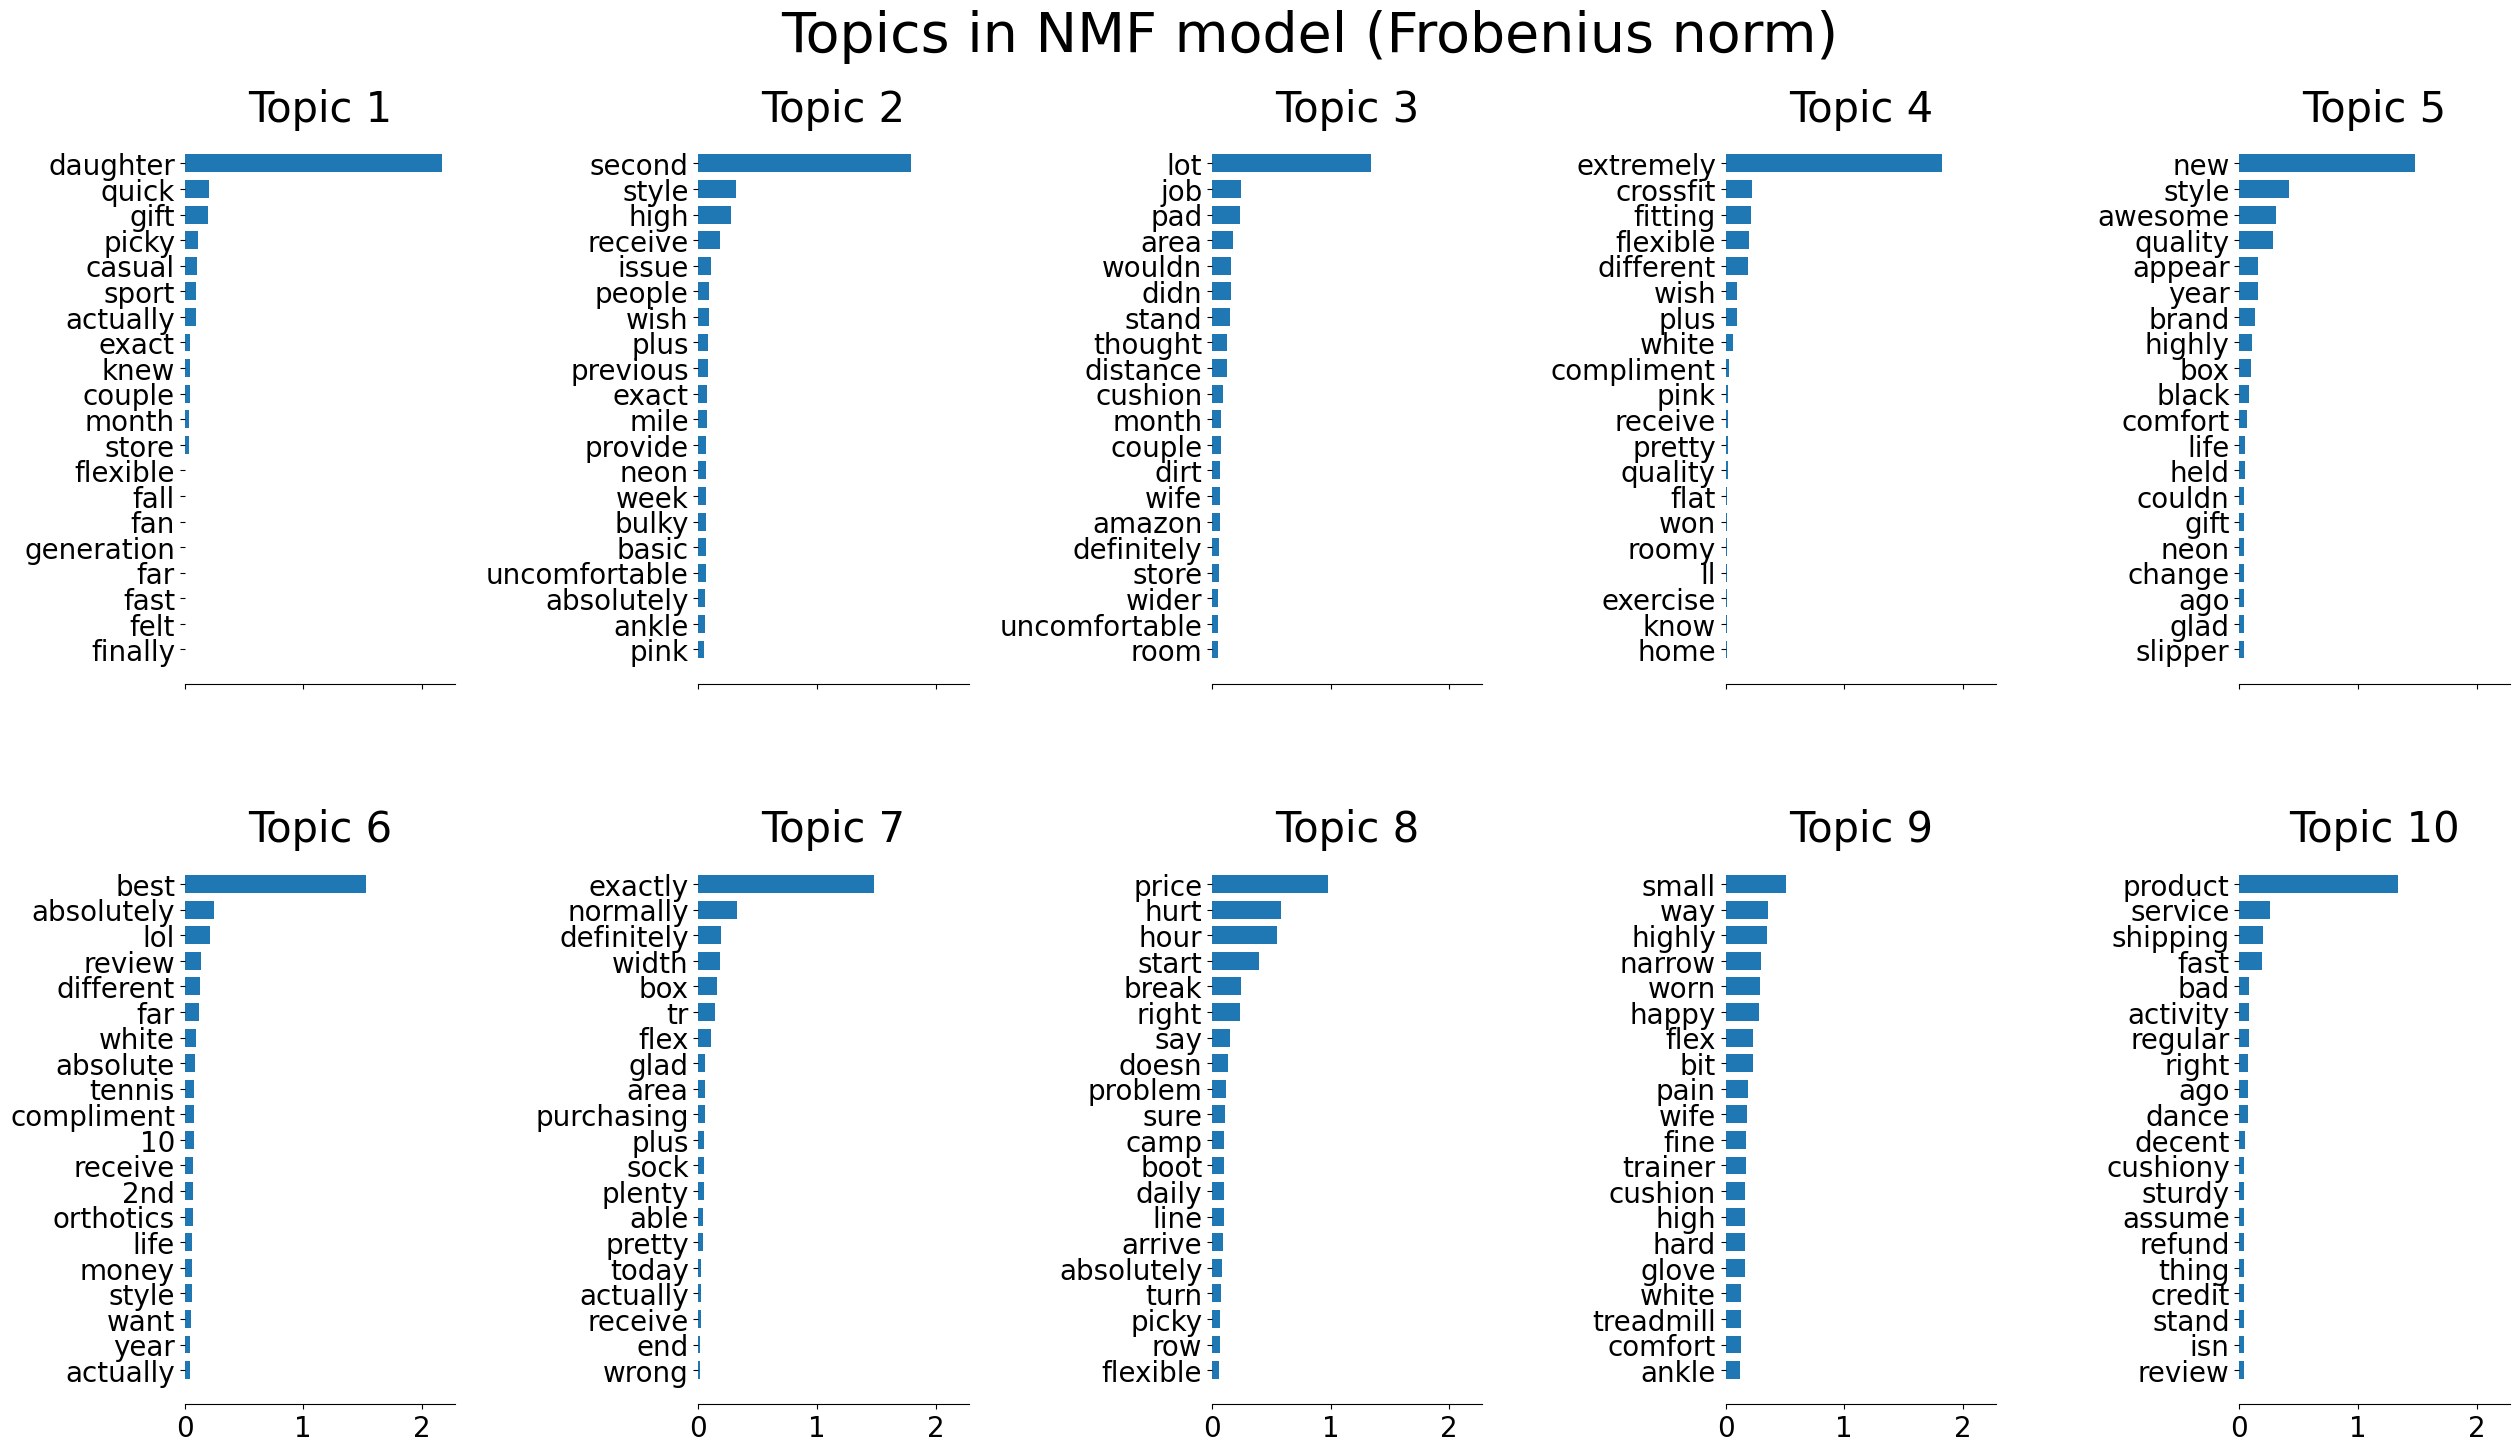

In [140]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, 
    tfidf_feature_names, 
    n_top_words, 
    "Topics in NMF model (Frobenius norm)"
)

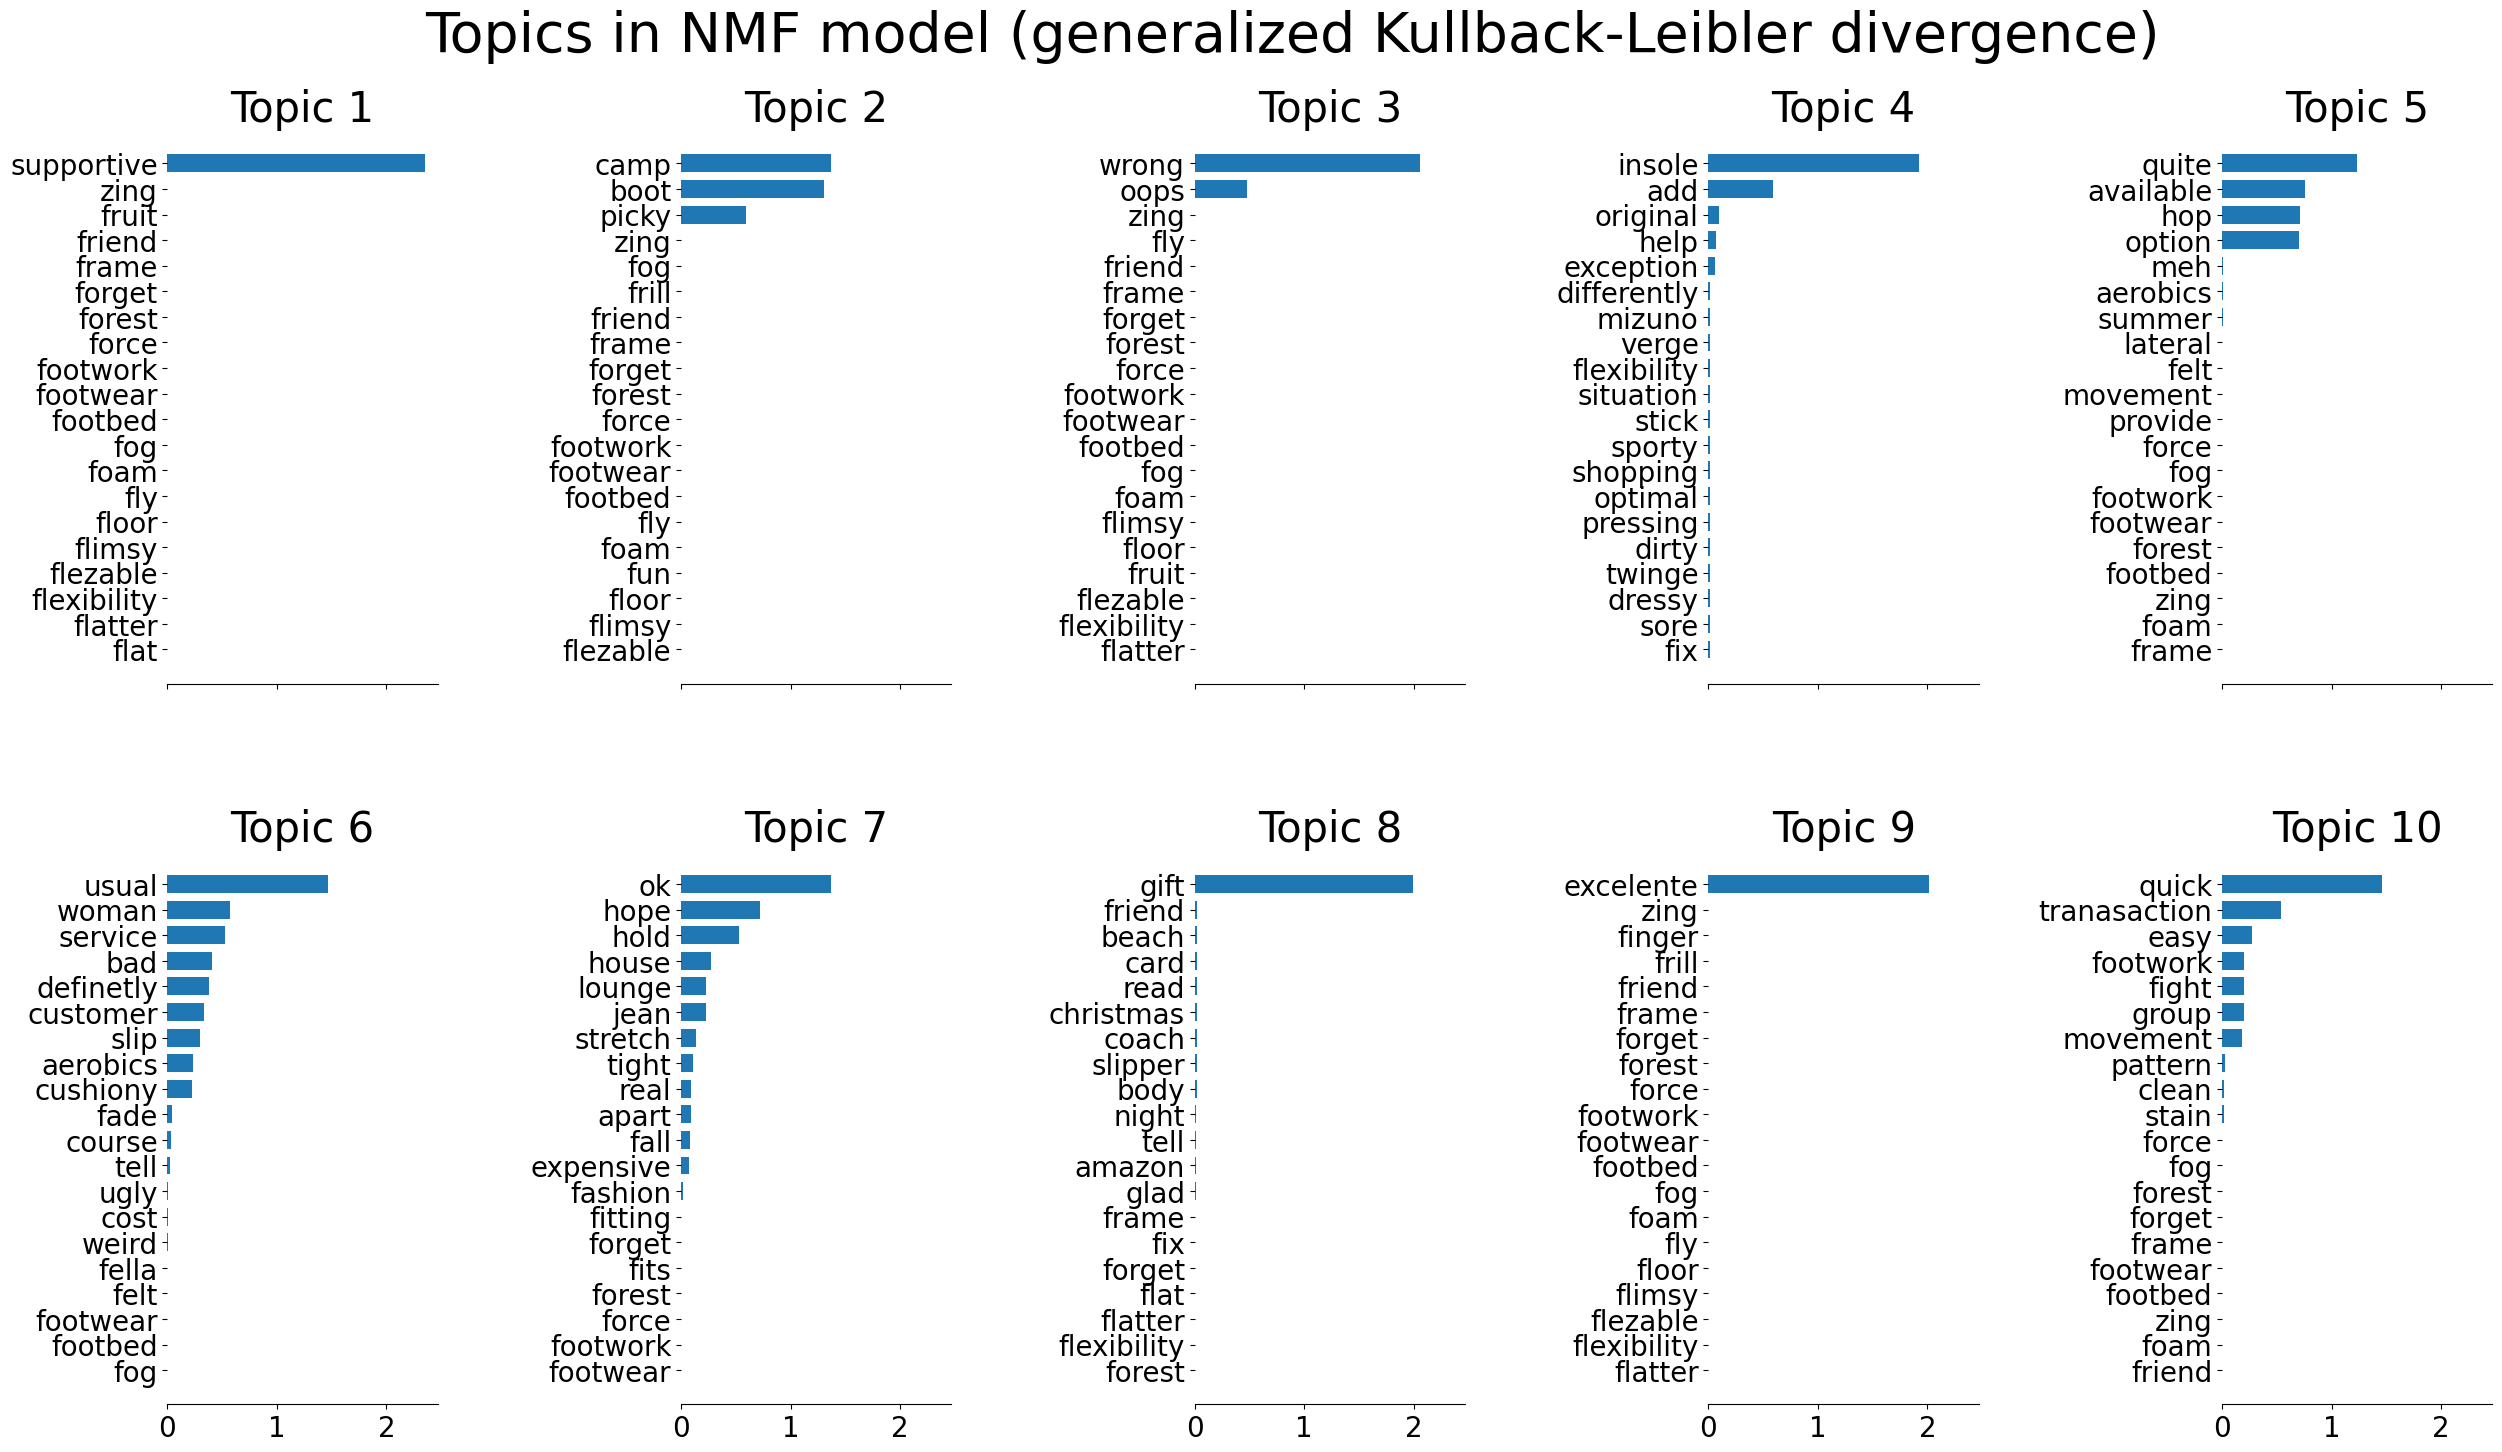

In [78]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

In [79]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


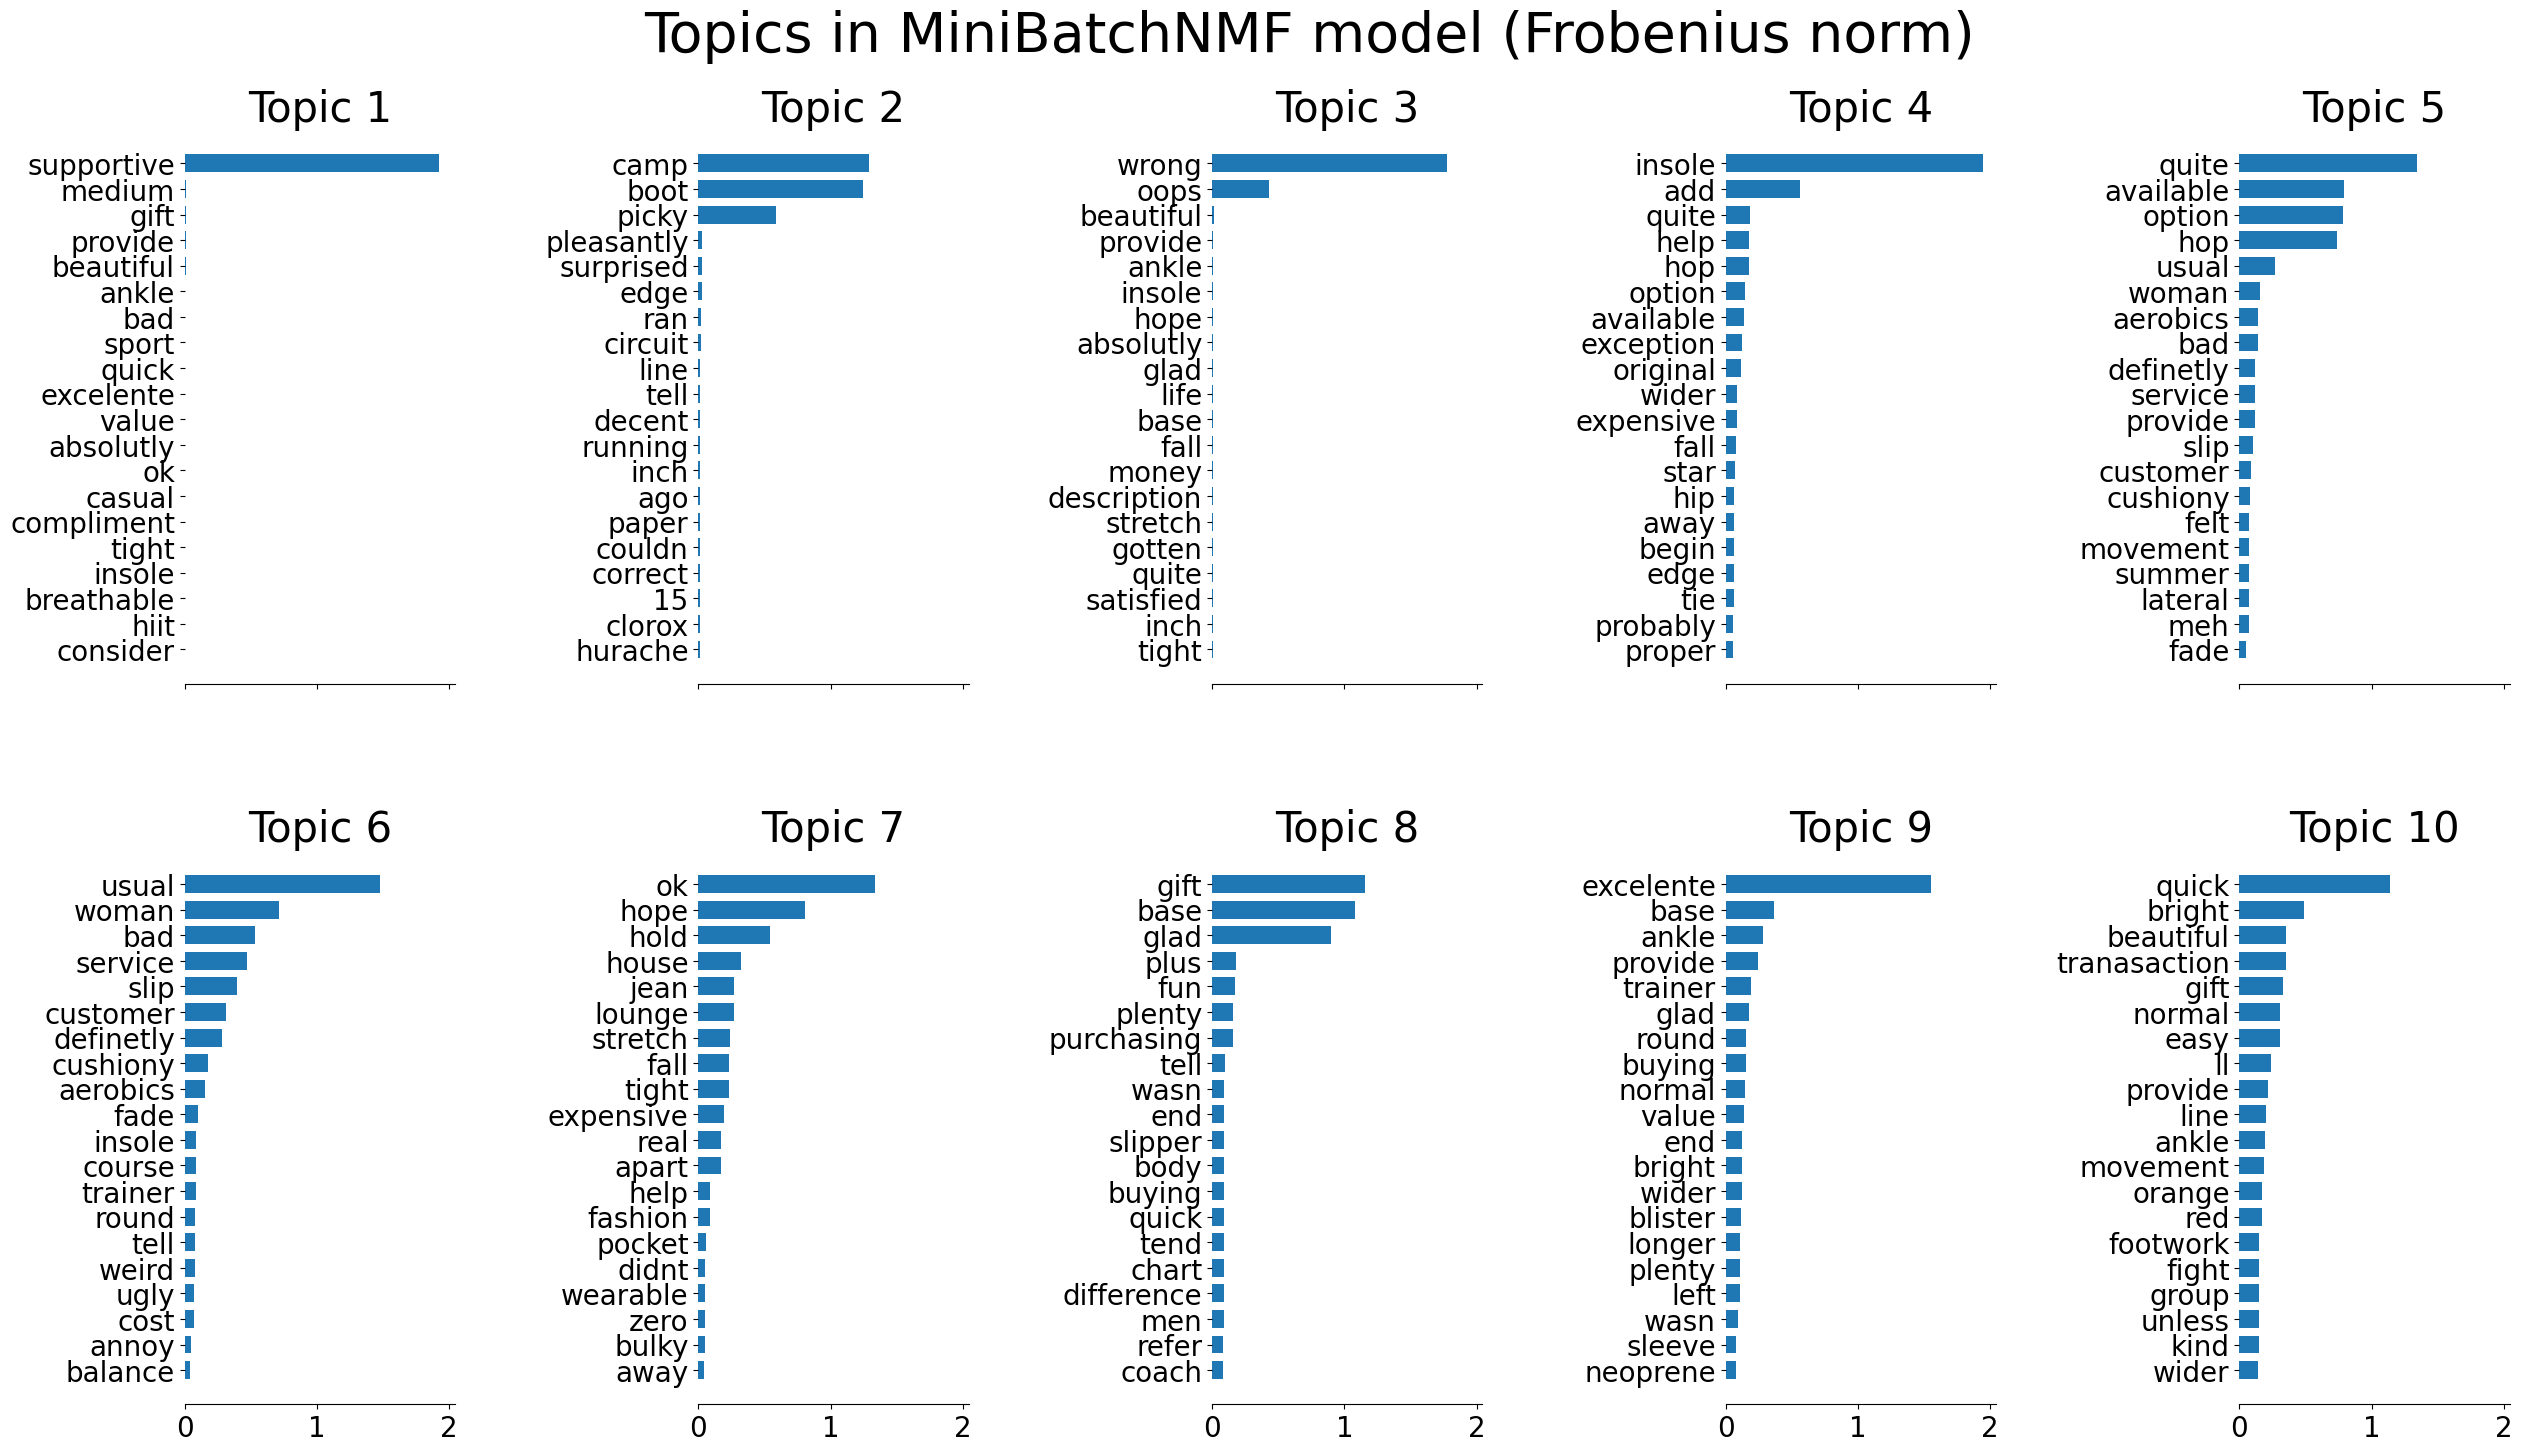

In [80]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

In [81]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


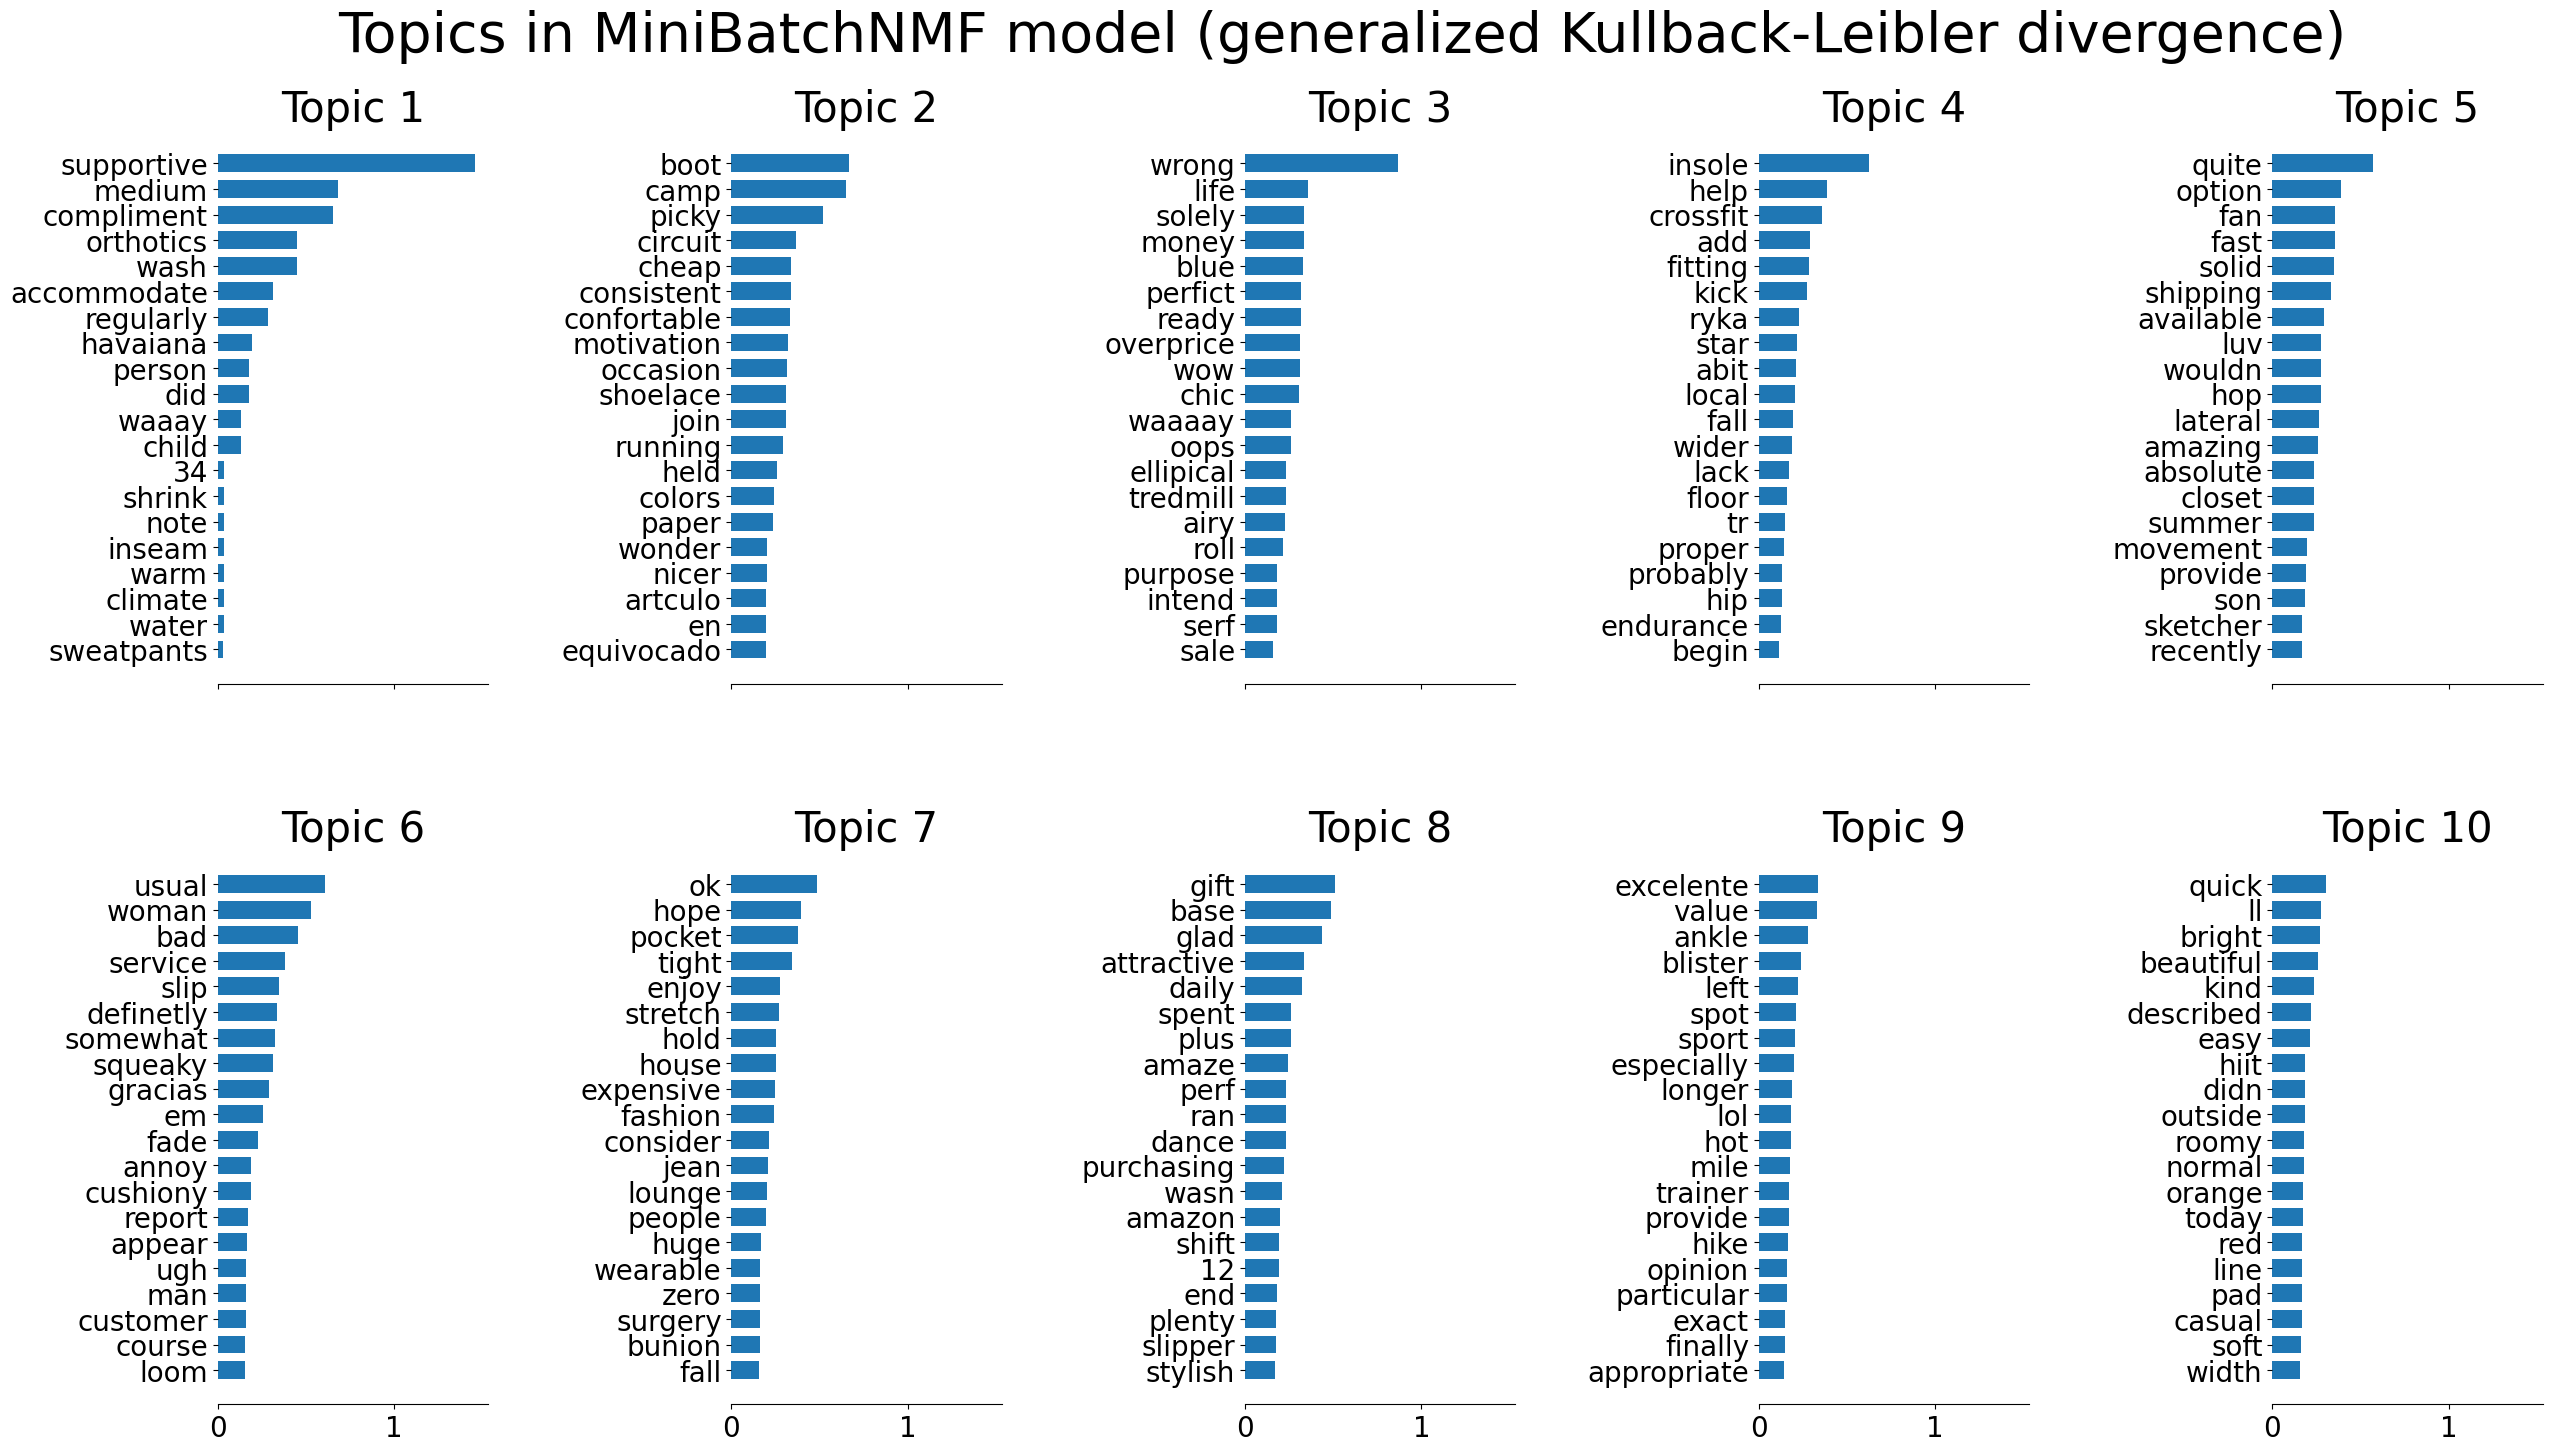

In [82]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

In [141]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.01, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)
tf_vectorizer.stop_words_

Extracting tf features for LDA...


{'000',
 '10',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'able',
 'absolutely',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'ache',
 'achilles',
 'activity',
 'actually',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'amazon',
 'ankle',
 'anymore',
 'apart',
 'arch',
 'area',
 'arose',
 'arrive',
 'artculo',
 'asics',
 'athletic',
 'attention',
 'away',
 'awesome',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'best',
 'big',
 'bit',
 'black',
 'blister',
 'blood',
 'bluff',
 'boot',
 'bootcamps',
 'bought',
 'box',
 'boxier',
 'brand',
 'break',
 'breath',
 'breathe',
 'breathes',
 'bright',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calf',
 'cam',
 'card',
 'cardio',
 'care',
 'careful',
 'carpet',
 'ca

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


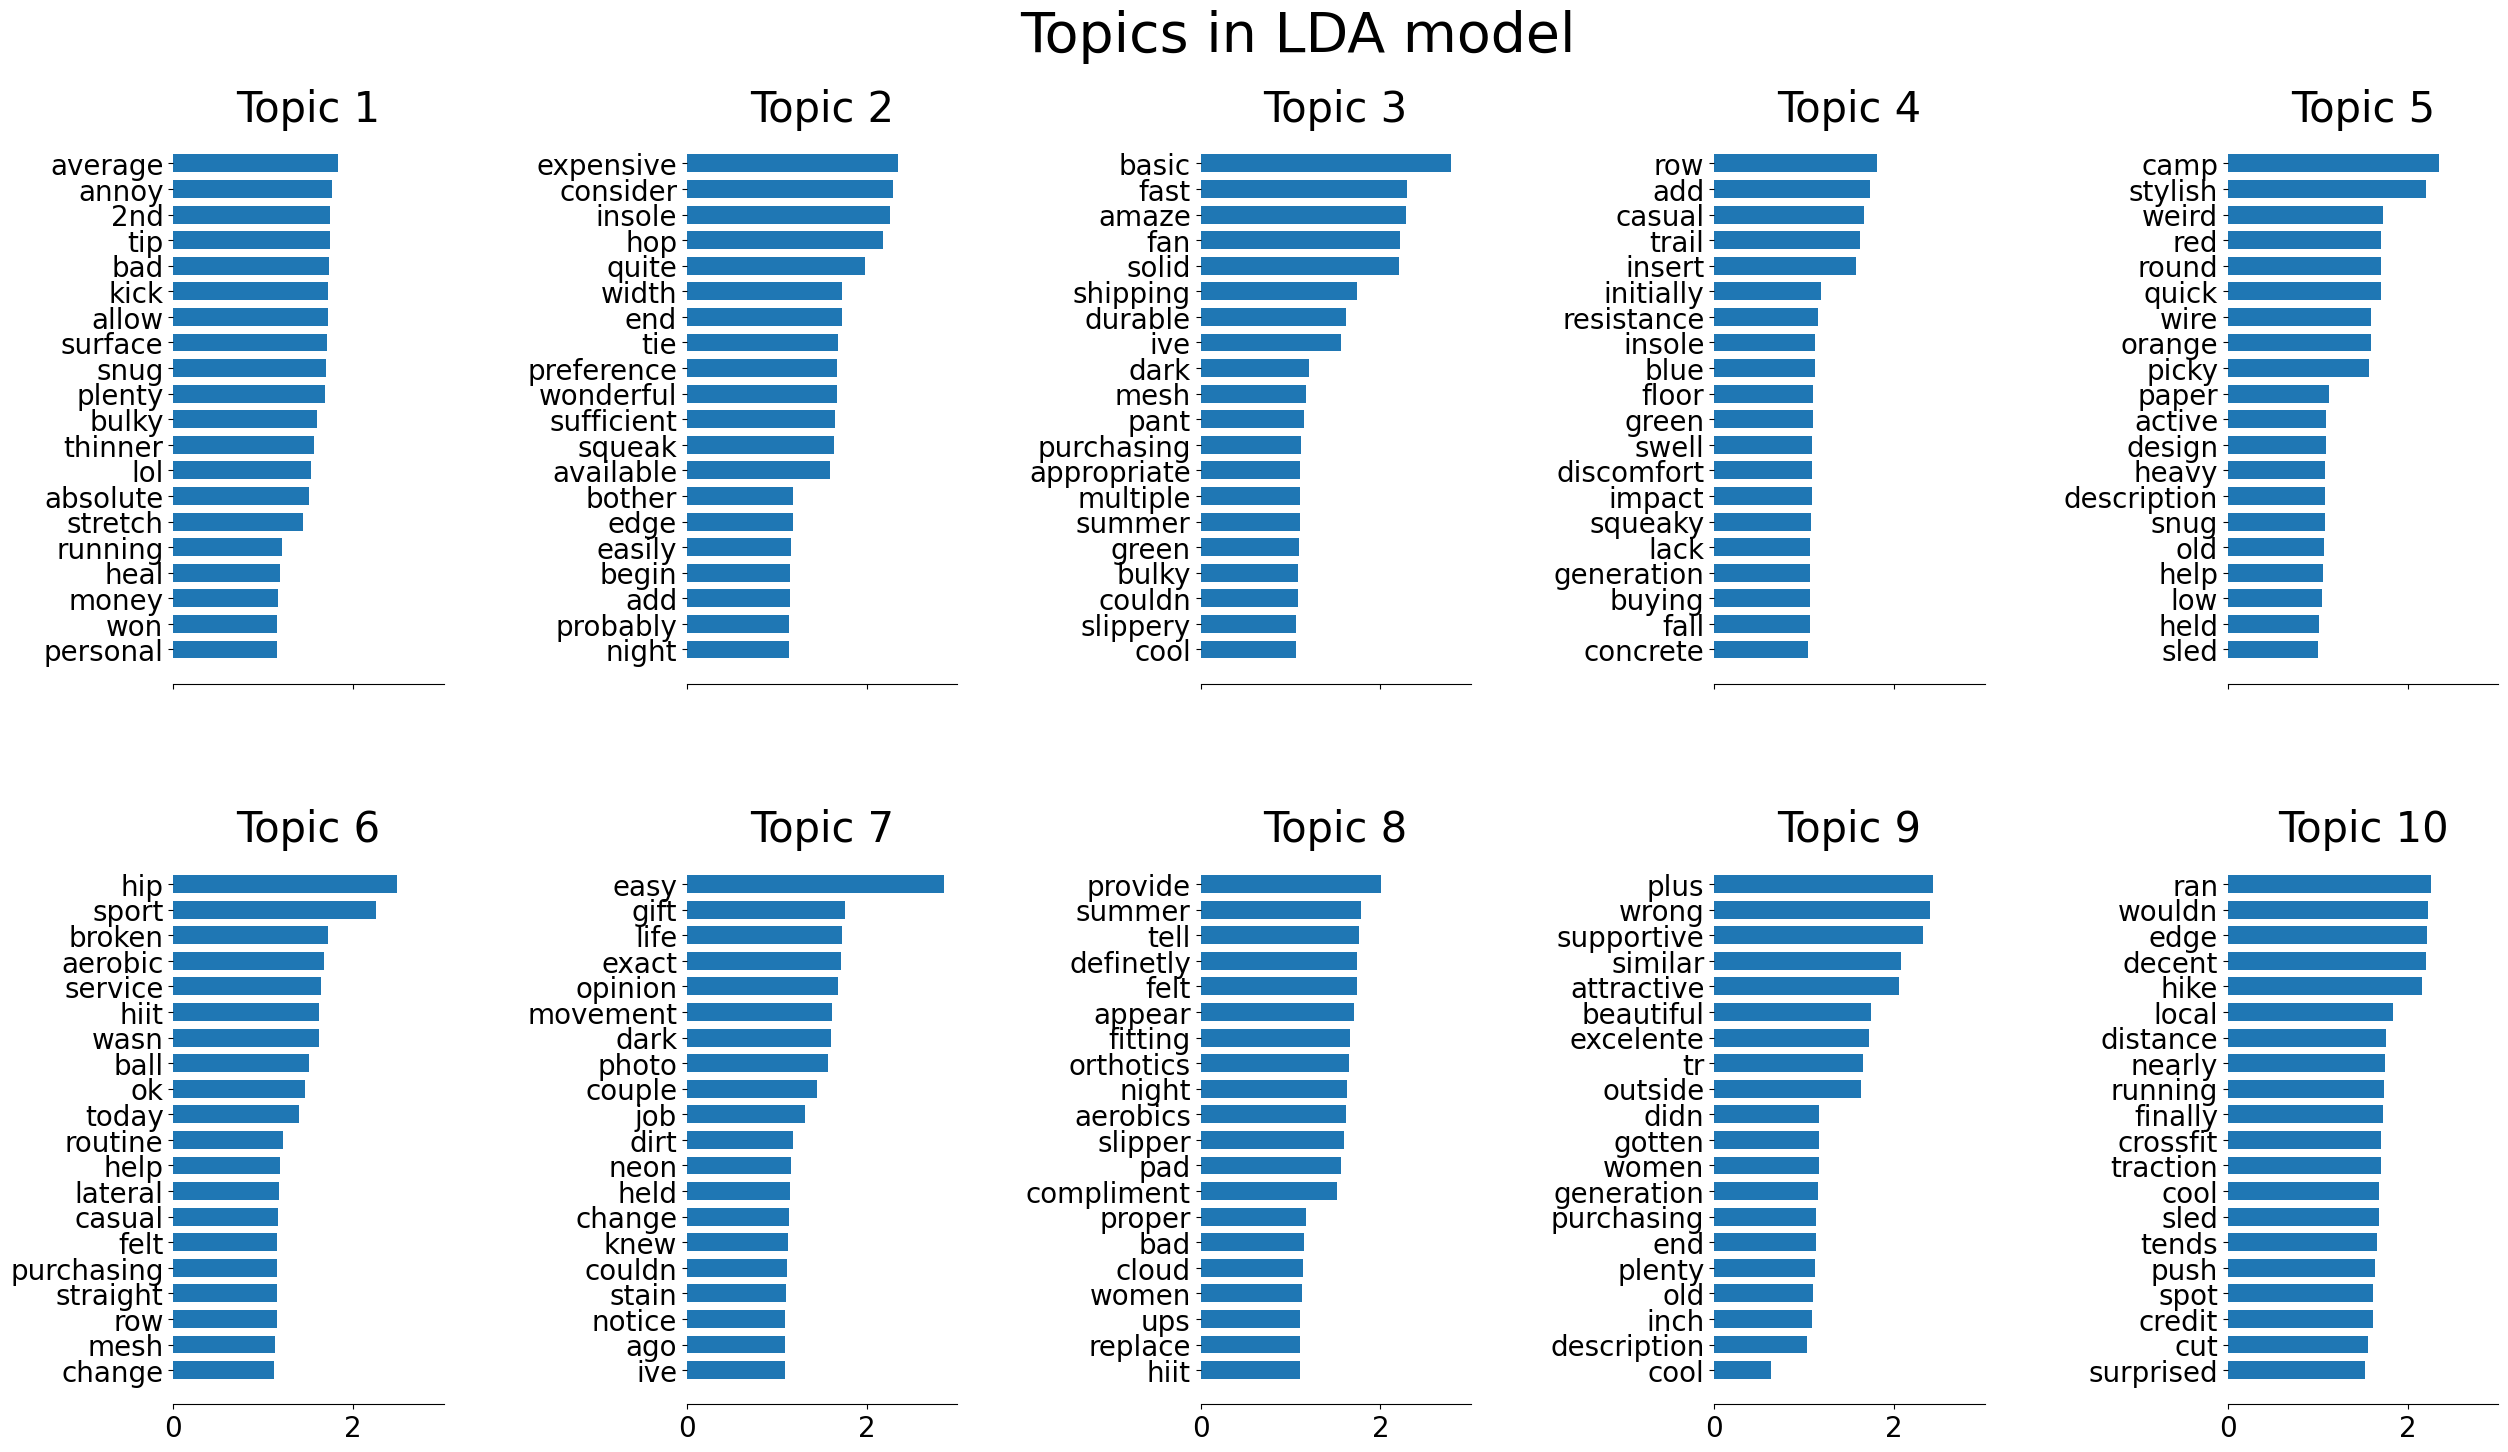

In [142]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [121]:
for i, sample in enumerate(data_samples):
    if len(sample) > 100 and len(sample) < 500:
        print(i,":", sample)

10 : relieve my plantar fascitis for 3 day then the unbearable pain return in full force these be recommend by my podiatrist
11 : this be my 6th pair and they be the best thing ever for my plantar fasciitis and resultant neuroma unfortunately the one i order from smartdestination must be second a they kill my foot the hard plastic insert rub on the outside edge of my foot i be unable to exchange them a i wait one day too late to use them in my walk shoe
13 : pinnacle seem to have more cushion so my husband like them well he's try all the other powerstep insert a well a other brand this be his must have insert he be 6'3" and weighs 257lbs with bone spur plantar fasciitis and a high instep he be very active and wear these in all his shoe his bone spur rarely bother him any more remember to replace them every 3 month if you wear them every day especially if you weigh more than average and/or run
15 : a little more cushion than the powerstep protech but the arch be maybe just a little low 

In [123]:
lda.transform(tf_vectorizer.transform([data_samples[13]]))

array([[0.00476198, 0.95714056, 0.0047619 , 0.0047619 , 0.00476277,
        0.0047621 , 0.00476222, 0.00476222, 0.00476242, 0.0047619 ]])

In [122]:
data_samples[13]

'pinnacle seem to have more cushion so my husband like them well he\'s try all the other powerstep insert a well a other brand this be his must have insert he be 6\'3" and weighs 257lbs with bone spur plantar fasciitis and a high instep he be very active and wear these in all his shoe his bone spur rarely bother him any more remember to replace them every 3 month if you wear them every day especially if you weigh more than average and/or run'